In [1]:
#! pip install datasets

In [2]:
! pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
import pandas as pd
from IPython.display import display
#from datasets import load_dataset
import cv2
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
#from torch.utils.data import Dataset
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
import time

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

#dataset = load_dataset("sjyhne/mapai_training_data", cache_dir="IKT452 - segmentation project/data")
#dataset = load_dataset('LOADING_SCRIPT', cache_dir="IKT452 - segmentation project/data")
#dataset.save_to_disk('dataset/')

## Dataset
The train and test data is downloaded from [HuggingFace](https://huggingface.co/datasets/sjyhne/mapai_training_data/tree/main)

The data is stored in .parquet files, and the training data is almost 7GB, and the val data is almost 1.5GB.


In [5]:
import pandas as pd
from IPython.display import display
#pd.read_parquet('dataset/train.parquet', engine='fastparquet')
train_data = pd.read_parquet('dataset/train.parquet')
# Display the data to understand it better
display(train_data)

,filename,image,lidar,mask,shape
0,6179_495_44.tif,"[112, 111, 109, 121, 119, 116, 113, 113, 111, ...","[9.549271, 9.793983, 9.793983, 10.201778, 10.2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[500, 500, 3]"
1,6051_690_84.tif,"[72, 86, 71, 77, 91, 74, 65, 80, 65, 75, 90, 7...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[500, 500, 3]"
2,6121_865_53.tif,"[170, 189, 203, 206, 219, 228, 200, 213, 224, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[500, 500, 3]"
3,6173_630_27.tif,"[116, 126, 146, 108, 118, 138, 110, 119, 139, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[500, 500, 3]"
4,6147_481_4.tif,"[53, 84, 87, 53, 84, 88, 59, 96, 95, 72, 109, ...","[0.013744354, -0.014642715, -0.014642715, -0.0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[500, 500, 3]"
...,...,...,...,...,...
6995,6248_475_72.tif,"[64, 79, 57, 64, 79, 58, 62, 77, 56, 63, 78, 5...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.04717827, 0.047178...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[500, 500, 3]"
6996,6204_705_29.tif,"[76, 63, 58, 114, 100, 96, 132, 123, 119, 133,...","[2.286316, 2.3601494, 2.3601494, 2.4384727, 2....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[500, 500, 3]"
6997,6188_551_71.tif,"[118, 152, 138, 156, 170, 163, 175, 179, 176, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[500, 500, 3]"
6998,6176_506_92.tif,"[65, 62, 62, 62, 60, 61, 66, 62, 63, 63, 59, 6...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[500, 500, 3]"


### EDA
Exploratory data analysis

In [6]:
from PIL import Image
import numpy as np

In [7]:
# Read RGB image from row 5
example_image = train_data['image'][5]
# It is stored as a list of ints
print(example_image)

[ 84 107 103 ...  90 117 111]


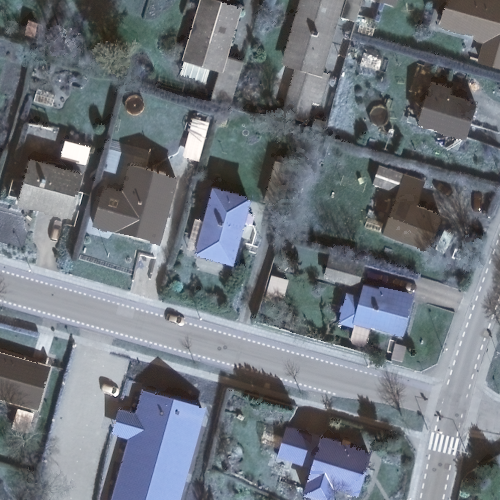

In [8]:
# Convert the list of numbers to a NumPy array of size 500x500x3
arr = np.array(example_image).reshape((500, 500, 3)).astype('uint8')

# Convert the NumPy array to a PIL Image object
img = Image.fromarray(arr)

# Display the image
img.show()

In [9]:
# convert img to np array just to see
im_arr_test = np.array(img.convert("RGB"))

In [10]:
example_mask = train_data['mask'][5]
mask_arr = np.array(example_mask).reshape((500, 500)).astype('uint8')
display(mask_arr)

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

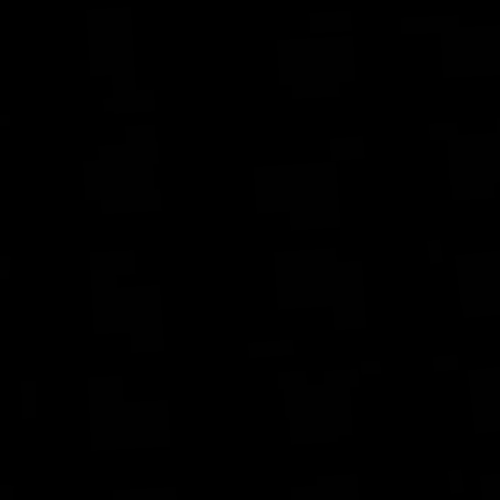

In [11]:
from PIL import Image, ImageOps
# Convert mask to np array
img_nr = 6
#example_mask = train_data['mask'][5]
shape = train_data["shape"].to_numpy()[img_nr]
example_mask = train_data["mask"].to_numpy()[img_nr].reshape((shape[:-1]))
mask_arr = np.array(example_mask).reshape((500, 500))#.astype('uint8')

image = train_data["image"].to_numpy()[img_nr].reshape((shape))

# Convert the NumPy array to a PIL Image object
#img = Image.fromarray(mask_arr)
img = Image.fromarray(example_mask)
#img = Image.fromarray(image)

# Convert the image to black and white
#img = ImageOps.invert(img)
# Display the image
img.show()

In [12]:
# Import the different torch stuff


#

In [13]:
# Find out how many images there is
len(train_data.index)

7000

In [14]:
# Takes a very long time
#train_data.describe()

### Data preperations
Save all the images in list
80/20 train test split

In [15]:
image_tensors = []
mask_tensors = []
images = []
masks = []
#training_images_tensors = []
#training_masks = []

In [16]:
# Transform to tensors
# Define a transform to convert the image to tensor
#transform = transforms.ToTensor()

# Convert the image to PyTorch tensor
#tensor = transform(image)


for index, row in train_data.iterrows():
    #print()
    im = row['image']
    ma = row['mask']
    img_arr = np.array(im).reshape((500, 500, 3)).astype('uint8')
    mask_arr = np.array(ma).reshape((500, 500)).astype('uint8')
    #img_tensor = torch.from_numpy(img_arr)
    #mask_tensor = torch.from_numpy(mask_arr)
    #print(im)
    #print(ma)
    images.append(img_arr)
    masks.append(mask_arr)
    # Add tensors to lists
    #image_tensors.append(img_tensor)
    #mask_tensors.append(mask_tensor)

In [17]:
len(images)
#len(masks)

7000

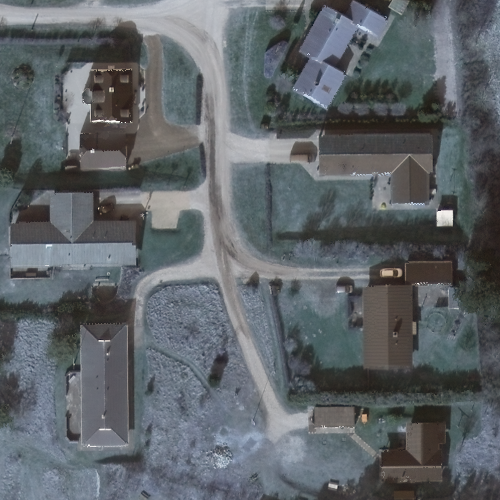

True


In [18]:
#print(images[4500])
arr = images[4500]
# Convert the NumPy array to a PIL Image object
img = Image.fromarray(arr)

# Display the image
img.show()

imarr = np.array(img)
comparison = arr == imarr
equal_arrays = comparison.all()
 
print(equal_arrays)

In [19]:
# https://stackabuse.com/numpy-array-to-tensor-and-tensor-to-numpy-array-with-pytorch/
#img_tensors = torch.Tensor(images[:100]).cuda
#mask_tensors = torch.Tensor(masks).cuda
#start_time = time.time()
#tens = torch.Tensor(images[:20])
#time_used = time.time() - start_time
#print(time_used)

[[[112 111 109]
  [121 119 116]
  [113 113 111]
  ...
  [ 70  90  85]
  [ 72  92  86]
  [ 66  86  80]]

 [[ 95  95  94]
  [116 115 112]
  [ 94  94  94]
  ...
  [ 74  95  89]
  [ 62  82  77]
  [ 65  84  78]]

 [[ 88  87  87]
  [107 106 103]
  [107 106 105]
  ...
  [ 96 116 106]
  [ 50  69  67]
  [ 41  61  59]]

 ...

 [[121 123 126]
  [121 124 126]
  [121 124 126]
  ...
  [ 65  61  56]
  [ 59  55  53]
  [ 61  57  55]]

 [[121 125 126]
  [121 124 126]
  [119 124 125]
  ...
  [ 59  56  51]
  [ 58  55  53]
  [ 62  59  56]]

 [[123 126 128]
  [120 124 125]
  [121 124 126]
  ...
  [ 56  53  50]
  [ 58  55  51]
  [ 68  64  59]]]


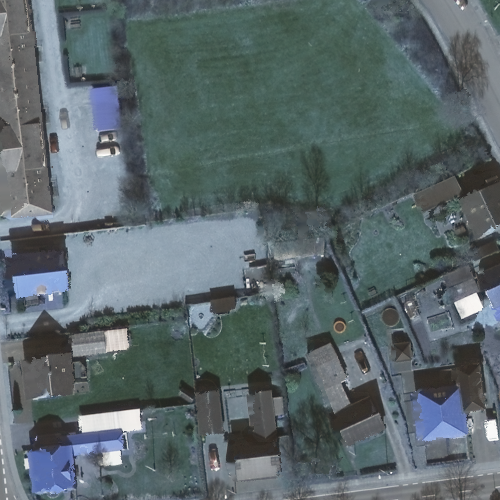

In [20]:
# Test converting list of np arrays to an array.
test_array = np.array(images[:1000])
print(test_array[0])
# Convert the NumPy array to a PIL Image object
img = Image.fromarray(test_array[0])

# Display the image
img.show()
#test_tensor = torch.Tensor(test_array)

### Convert to Tensors and create datasets and DataLoaders

In [21]:
# Create img and mask tensors
# Convert to np array to speed up tensor conversion
img_array = np.array(images)
mask_array = np.array(masks)

# Convert to tensor
train_img_tensor = torch.Tensor(img_array[:5600])
train_mask_tensor = torch.Tensor(mask_array[:5600])

test_img_tensor = torch.Tensor(img_array[5600:])
test_mask_tensor = torch.Tensor(mask_array[5600:])

# Convert to tensor
#train_img_tensor = torch.Tensor(img_array[:2000])
#train_mask_tensor = torch.Tensor(mask_array[:2000])

#test_img_tensor = torch.Tensor(img_array[2000:2500])
#test_mask_tensor = torch.Tensor(mask_array[2000:2500])

In [22]:
# Save tensor locally
# https://androidkt.com/how-to-save-and-load-pytorch-tensor-to-file/#:~:text=How%20to%20save%20and%20load%20PyTorch%20Tensor%20to,...%203%20Serializing%20to%20HDF5%20with%20h5py%20
#torch.save(img_tensors, 'img_tensor_saved.t')
#torch.save(mask_tensor, 'mask_tensor_saved.t')

In [23]:
#dataset_ = TensorDataset(img_tensors, mask_tensors)

class Dataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        
        if self.transform:
            image = Image.fromarray(self.images[idx].astype(np.uint8).transpose(1,2,0))
            image = self.transform(image)
            mask = Image.fromarray(self.masks[idx].astype(np.uint8).transpose(1,2,0))
            mask = self.transform(mask)
            
        return image, mask


In [24]:
# Create train test split
#train_images = images[:5600]
#test_images = images[5600:]

#train_masks = masks[:5600]
#test_masks = masks[5600:]

In [25]:
# Convert to Tensor. Only use 1000 images as 7000 takes a long time
#train_images = torch.Tensor(images[:800])
#test_images = torch.Tensor(images[800:1000])

#train_masks = torch.Tensor(masks[:800])
#test_masks = torch.Tensor(masks[800:1000])

In [26]:
train_dataset = TensorDataset(train_img_tensor, train_mask_tensor)
test_dataset = TensorDataset(test_img_tensor, test_mask_tensor)

In [27]:
# Create DataLoader objects
train_dataloader = DataLoader(train_dataset, batch_size = 32, pin_memory=True, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 32, pin_memory=True, shuffle = False)
#train_dataloader = DataLoader(train_dataset, batch_size = 4, num_workers = 2, shuffle = True)
#test_dataloader = DataLoader(test_dataset, batch_size = 4, num_workers = 2, shuffle = False)
#transform = transforms.Compose([transforms.ToTensor()])
#ds = Dataset(images, masks, transform=transform)
#train_dataloader = DataLoader(ds, batch_size=4, num_workers=2, shuffle=True)
#train_dataloader = DataLoader(ds, batch_size=32, shuffle=True)
#test_dataloader = DataLoader(test_dataset, batch_size = 4, num_workers = 2, shuffle = False)

In [28]:
len(train_dataloader.dataset)
#len(X_train)

5600

In [29]:
#img, mask = train_dataloader[0]

### Testing Datalaoder
Show that it is possible to get both image and mask from DataLoader

torch.Size([32, 500, 500, 3])
torch.Size([32, 500, 500])


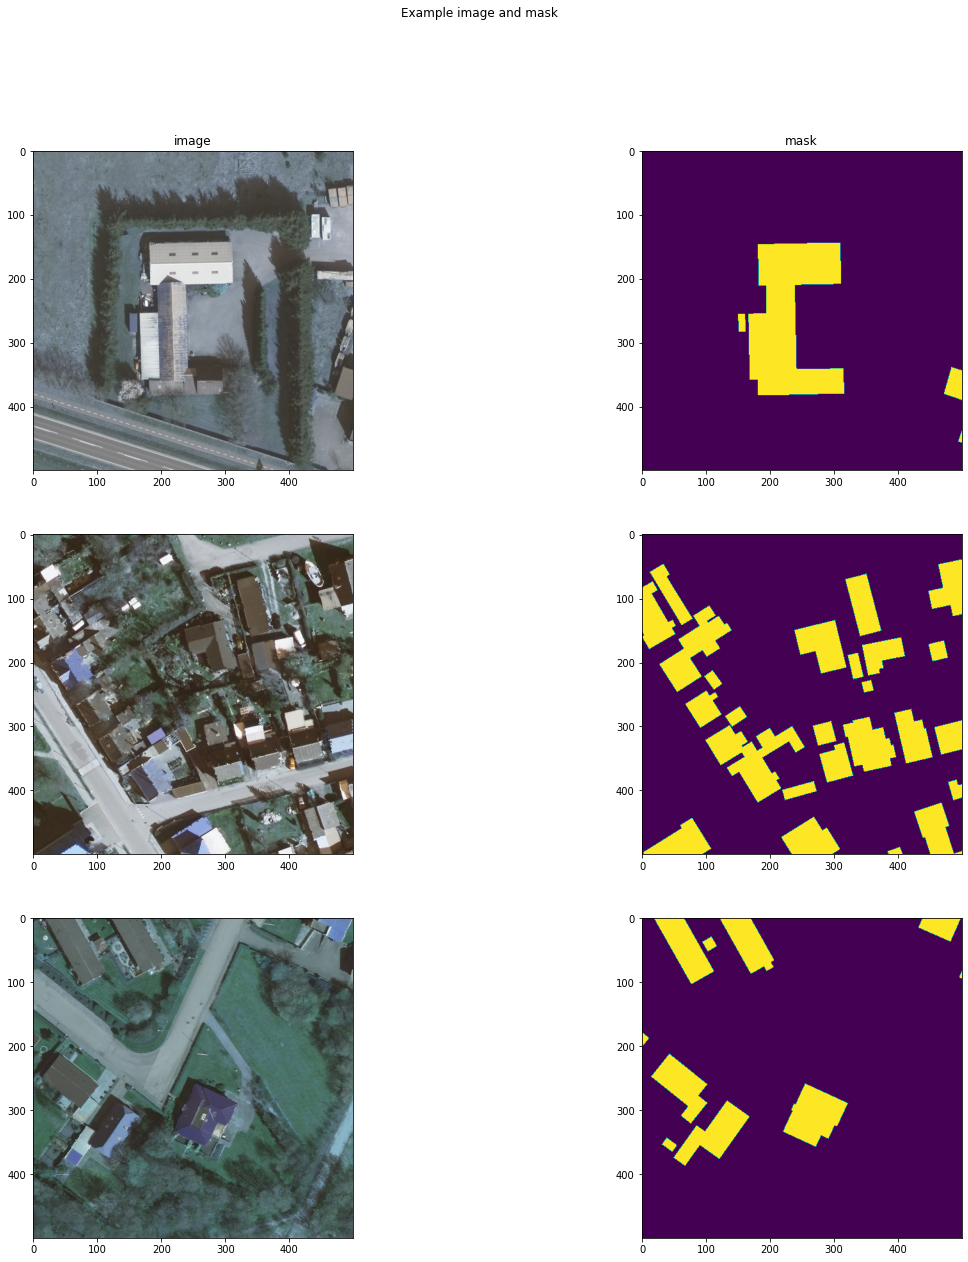

In [30]:
inputs, masks = next(iter(train_dataloader))

print(inputs.shape)
print(masks.shape)

#image = inputs[0].numpy()
#print(image.astype(np.uint8))
#img = Image.fromarray(image.astype(np.uint8))
# Display the image
#img.show()

fig, ax = plt.subplots(3,2, figsize=(20,20))
fig.suptitle('Example image and mask')
ax[0,0].imshow(inputs[0].int())#permute(0,1,2))
ax[0,0].set_title('image')
ax[0,1].imshow(masks[0])
ax[0,1].set_title('mask')

ax[1,0].imshow(inputs[1].int())#permute(0,1,2))
ax[1,1].imshow(masks[1])

ax[2,0].imshow(inputs[2].int())#permute(0,1,2))
ax[2,1].imshow(masks[2])
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
#plt.title('Example image and mask')
plt.savefig('exampleimages_3.png')
plt.show()

## Model and training

In [31]:
#class Net:
    


import segmentation_models_pytorch as smp
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

ENCODER = 'efficientnet-b3'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['grid']
ACTIVATION = 'sigmoid'
DEVICE = device

model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
).to(DEVICE)

In [32]:
# https://www.kaggle.com/code/cordmaur/38-cloud-simple-unet

class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 3, 1)
        #self.conv1 = self.contract_block(in_channels, 32, 3, 2)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)
        #self.conv3 = self.contract_block(64, 64, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        #self.upconv3 = self.expand_block(64, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        print(f'conv1{conv1.shape}')
        conv2 = self.conv2(conv1)
        print(f'conv2{conv2.shape}')
        conv3 = self.conv3(conv2)
        print(f'conv3{conv3.shape}')
        
        upconv3 = self.upconv3(conv3)
        #print(conv2.shape)
        print(f'upconv3{upconv3.shape}')

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):
        print(f'padding:{padding}')

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

# Another Unet model implementation
# https://github.com/aryaman-sh/model-implementations-PyTorch/blob/main/UNET/UNET_retain_imageDim.ipynb

import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class Section(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(Section, self).__init__()
        self.process = nn.Sequential(
            nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv3d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding='same'),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.process(x)


class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNET, self).__init__()
        # Contraction
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        self.down1 = Section(in_channels=in_channels, out_channels=64, kernel_size=3)
        self.down2 = Section(in_channels=64, out_channels=128, kernel_size=3)
        self.down3 = Section(in_channels=128, out_channels=256, kernel_size=3)
        self.down4 = Section(in_channels=256, out_channels=512, kernel_size=3)
        self.down5 = Section(in_channels=512, out_channels=1024, kernel_size=3)
        # Expansion
        self.up_conv1 = nn.ConvTranspose3d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)
        self.up_conv2 = nn.ConvTranspose3d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        self.up_conv3 = nn.ConvTranspose3d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.up_conv4 = nn.ConvTranspose3d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.up1 = Section(in_channels=1024, out_channels=512, kernel_size=3)
        self.up2 = Section(in_channels=512, out_channels=256, kernel_size=3)
        self.up3 = Section(in_channels=256, out_channels=128, kernel_size=3)
        self.up4 = Section(in_channels=128, out_channels=64, kernel_size=3)
        self.output = self.final_conv = nn.Conv3d(64, out_channels, kernel_size=1, padding='same')
        
    def forward(self, x):
        skip_connections = []
        
        # CONTRACTION
        # down 1
        x = self.down1(x)
        skip_connections.append(x)
        x = self.pool(x)
        # down 2
        x = self.down2(x)
        skip_connections.append(x)
        x = self.pool(x)
        # down 3
        x = self.down3(x)
        skip_connections.append(x)
        x = self.pool(x)
        # down 4
        x = self.down4(x)
        skip_connections.append(x)
        x = self.pool(x)
        # down 5
        x = self.down5(x)
        
        # EXPANSION
        # up1
        x = self.up_conv1(x)
        y = skip_connections[3]
        x = TF.resize(x, y.shape[2:])
        y_new = torch.cat((y, x), dim=1)
        x = self.up1(y_new)
        # up2
        x = self.up_conv2(x)
        y = skip_connections[2]
        # resize skip commention
        x = TF.resize(x, y.shape[2:])
        y_new = torch.cat((y, x), dim=1)
        x = self.up2(y_new)
        # up3
        x = self.up_conv3(x)
        y = skip_connections[1]
        x = TF.resize(x, y.shape[2:])
        y_new = torch.cat((y, x), dim=1)
        x = self.up3(y_new)
        # up4 
        x = self.up_conv4(x)
        y = skip_connections[0]
        x = TF.resize(x, y.shape[2:])
        y_new = torch.cat((y, x), dim=1)
        x = self.up4(y_new)
        
        x = self.output(x)
        return x
        
model = UNET() 

In [33]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

In [34]:
class Section(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(Section, self).__init__()
        self.process = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding='same'),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.process(x)

In [35]:
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNET, self).__init__()
        # Contraction
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down1 = Section(in_channels=in_channels, out_channels=64, kernel_size=3)
        self.down2 = Section(in_channels=64, out_channels=128, kernel_size=3)
        self.down3 = Section(in_channels=128, out_channels=256, kernel_size=3)
        #self.down4 = Section(in_channels=256, out_channels=512, kernel_size=3)
        #self.down5 = Section(in_channels=512, out_channels=1024, kernel_size=3)
        # Expansion
        #self.up_conv1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)
        #self.up_conv2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        self.up_conv3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.up_conv4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        #self.up1 = Section(in_channels=1024, out_channels=512, kernel_size=3)
        #self.up2 = Section(in_channels=512, out_channels=256, kernel_size=3)
        self.up3 = Section(in_channels=256, out_channels=128, kernel_size=3)
        self.up4 = Section(in_channels=128, out_channels=64, kernel_size=3)
        self.output = self.final_conv = nn.Conv2d(64, out_channels, kernel_size=3, padding='same')
        
    def forward(self, x):
        skip_connections = []
        
        # CONTRACTION
        # down 1
        x = self.down1(x)
        skip_connections.append(x)
        x = self.pool(x)
        # down 2
        x = self.down2(x)
        skip_connections.append(x)
        x = self.pool(x)
        # down 3
        x = self.down3(x)
        #skip_connections.append(x)
        #x = self.pool(x)
        # down 4
        #x = self.down4(x)
        #skip_connections.append(x)
        #x = self.pool(x)
        # down 5
        #x = self.down5(x)
        
        # EXPANSION
        # up1
        #x = self.up_conv1(x)
        #y = skip_connections[3]
        #x = TF.resize(x, y.shape[2:])
        #y_new = torch.cat((y, x), dim=1)
        #x = self.up1(y_new)
        # up2
        #x = self.up_conv2(x)
        #y = skip_connections[2]
        # resize skip commention
        #x = TF.resize(x, y.shape[2:])
        #y_new = torch.cat((y, x), dim=1)
        #x = self.up2(y_new)
        # up3
        x = self.up_conv3(x)
        y = skip_connections[1]
        x = TF.resize(x, y.shape[2:])
        y_new = torch.cat((y, x), dim=1)
        x = self.up3(y_new)
        # up4 
        x = self.up_conv4(x)
        y = skip_connections[0]
        x = TF.resize(x, y.shape[2:])
        y_new = torch.cat((y, x), dim=1)
        x = self.up4(y_new)
        
        x = self.output(x)
        return x
        
#model = UNET() 

In [36]:
#unet = UNET(3,2)

In [37]:
# testing one pass
xb, yb = next(iter(train_dataloader))
xb.shape, yb.shape


(torch.Size([32, 500, 500, 3]), torch.Size([32, 500, 500]))

In [38]:
xb = xb.permute(0,3,1,2)
xb.shape


torch.Size([32, 3, 500, 500])

In [39]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#device = 'cpu'
print(f'Device for training: {device}')

cuda


In [40]:
model = UNET()
model.to(device=device)

UNET(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down1): Section(
    (process): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): ReLU(inplace=True)
    )
  )
  (down2): Section(
    (process): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): ReLU(inplace=True)
    )
  )
  (down3): Section(
    (process): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): ReLU(inplace=True)
    )
  )
  (up_conv3): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (up_conv4): ConvTranspose

In [41]:
def dice_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

def dice_loss(inputs, target):
    num = target.size(0)
    inputs = inputs.reshape(num, -1)
    target = target.reshape(num, -1)
    smooth = 1.0
    intersection = (inputs * target)
    dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
    dice = 1 - dice.sum() / num
    return dice

def bce_dice_loss(inputs, target):
    dicescore = dice_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

In [42]:
def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.cuda()).float().mean()

In [43]:
# https://github.com/nikhilroxtomar/Retina-Blood-Vessel-Segmentation-in-PyTorch/blob/main/UNET/train.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

In [44]:
epochs = 50
learning_rate = 0.0001
#criterion = torch.nn.BCELoss(reduction='mean')
#criterion = torch.nn.BCELoss()
#criterion = torch.nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler to change the learning rate when the model stops to improve
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min', patience=5, verbose=True)

#loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = loss_fn = DiceBCELoss()
#loss_fn = torch.nn.BCELoss()
#loss_fn = torch.nn.BCEWithLogitsLoss()
#loss_fn = bce_dice_loss()
#opt = torch.optim.Adam(unet.parameters(), lr=0.01)

# Add scheduler?
# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html

In [45]:
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
def calculate_metrics(y_true, y_pred):
    """ Ground truth """
    y_true = y_true.cpu().numpy()
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)

    """ Prediction """
    y_pred = y_pred.cpu().numpy()
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    score_jaccard = jaccard_score(y_true, y_pred, average='micro')
    score_f1 = f1_score(y_true, y_pred, average='micro')
    score_recall = recall_score(y_true, y_pred, average='micro')
    score_precision = precision_score(y_true, y_pred, average='micro')
    score_acc = accuracy_score(y_true, y_pred)

    return [score_jaccard, score_f1, score_recall, score_precision, score_acc]

In [46]:
torch.cuda.empty_cache()
with torch.no_grad():
    xb = xb.to(device=device)
    pred = model(xb)
    pred.shape

In [47]:
# Get IOU
# Test torchmetrics jaccard index
from torchmetrics.classification import BinaryJaccardIndex
def get_iou_score(pred_tensor, target_tensor):
    
    predicitons = pred_tensor
    predicitons = torch.sigmoid(predicitons)    # Not sure if should use this, have to test
    predicitons = torch.squeeze(predicitons)    # Remove the dimension with a 1 to make it same shape as target/mask.
    #predicitons = predicitons.cpu()
    #print(predicitons.shape)
    
    targets = target_tensor    # target mask
    #targets = targets.cpu()
    #print(targets.shape)

    # https://torchmetrics.readthedocs.io/en/stable/classification/jaccard_index.html
    metric = BinaryJaccardIndex(threshold=0.5).to(device=device)
    result_iou = metric(predicitons, targets)
    #print(result_iou.item())
    
    return result_iou.item()

In [48]:
#%%capture output
# Command to make it possible to close notebook tab and reopen it
# Training
from tqdm import tqdm  # For nice progress bar!
train_loss = []
test_loss = []
enr = 0
train_iou = []
test_iou = []
    
for epoch in tqdm(range(epochs)):
    torch.cuda.empty_cache()

    #print(f'Epoch nr {enr}')
    #enr += 1
    
    train_run_loss = 0
    test_run_loss = 0
    
    train_run_iou = 0
    test_run_iou = 0
    
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    
    for i, data in enumerate(train_dataloader):
        torch.cuda.empty_cache()
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)

        # Zero your gradients for every batch!
        optimiser.zero_grad()

        # Make predictions for this batch
        inputs = inputs.permute(0,3,1,2)
        #print(inputs.shape)
        outputs = model(inputs)
        #labels = labels.long()
        
        # Get IOU for the batch
        iou_train_value = get_iou_score(outputs, labels)
        train_run_iou += iou_train_value
        #print(outputs.shape)
        #print(labels.shape)
        #print(outputs)
        #print(labels)
        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        #train_loss.append(loss)
        train_run_loss += loss
        loss.backward()

        # Adjust learning weights
        optimiser.step()
        
    # Get average train loss for the epoch
    train_losses = train_run_loss / len(train_dataloader)
    train_loss.append(train_losses)
    # Get average iou for the epoch
    train_avg_iou = train_run_iou / len(train_dataloader)
    train_iou.append(train_avg_iou)
    model.train(False)
    
    model.eval()
    with torch.no_grad():# Very important to have this line or else the gpu runs out of memory
        for j, data in enumerate(test_dataloader):
            torch.cuda.empty_cache()
            test_inputs, test_labels = data
            test_inputs = test_inputs.to(device=device)
            test_labels = test_labels.to(device=device)

            test_inputs = test_inputs.permute(0,3,1,2)

            res_output = model(test_inputs)
            
            # Get IOU for the batch
            #print(res_output.shape)
            #print(test_labels.shape)
            iou_test_value = get_iou_score(res_output, test_labels)
            test_run_iou += iou_test_value
            
            #test_labels = test_labels.long()
            test_losses = loss_fn(res_output, test_labels)
            test_run_loss += test_losses
            #test_loss.append(test_losses)
        
        # Get average test loss for the epoch
        test_losses = test_run_loss / len(test_dataloader)
        test_loss.append(test_losses)
        # Get average iou for the epoch
        test_avg_iou = test_run_iou / len(test_dataloader)
        test_iou.append(test_avg_iou)

100%|██████████| 40/40 [5:49:44<00:00, 524.62s/it]  


In [49]:
#output.show()

In [50]:
# Testing
#print(train_loss)
#ya = torch.stack(train_loss).cpu()
#print(ya)
#yb = [t.item() for t in train_loss]
#print(yb)

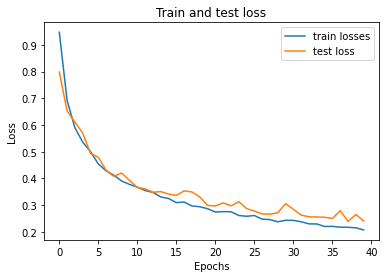

In [51]:
# Plot
plt.title(f'Train and test loss')
x = [x for x in range(epochs)]
train_loss_ = [t.item() for t in train_loss]
test_loss_ = [t.item() for t in test_loss]
plt.plot(x, train_loss_, label='train losses')
plt.plot(x, test_loss_, label='test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_diceBce_4_15.05.23.png')
plt.show()

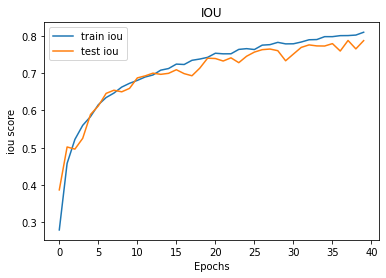

In [52]:
# Plot iou
plt.title(f'IOU')
x = [x for x in range(epochs)]
#train_iou_ = [t.item() for t in train_iou]
#test_iou_ = [t.item() for t in test_iou]
plt.plot(x, train_iou, label='train iou')
plt.plot(x, test_iou, label='test iou')
plt.xlabel('Epochs')
plt.ylabel('iou score')
plt.legend()
plt.savefig('iou_4_15.05.23.png')
plt.show()

In [74]:
# Print results
# avg loss on last epoch
avg_train_loss = train_loss_[-1]
avg_test_loss = test_loss_[-1]

# avg iou on last epoch
avg_train_iou = train_iou[-1]
avg_test_iou = test_iou[-1]

print(f'Train loss: {avg_train_loss}')
print(f'Test loss: {avg_test_loss}')
print(f'Train iou: {avg_train_iou}')
print(f'Test iou: {avg_test_iou}')
print(f'Epochs: {epochs}')
print(f'Learning rate: {learning_rate}')

Train loss: 0.20747019350528717
Test loss: 0.24106167256832123
Train iou: 0.8097699117660523
Test iou: 0.7872625846754421
Epochs: 40
Learning rate: 0.0001


torch.Size([32, 500, 500, 3])
torch.Size([32, 500, 500])


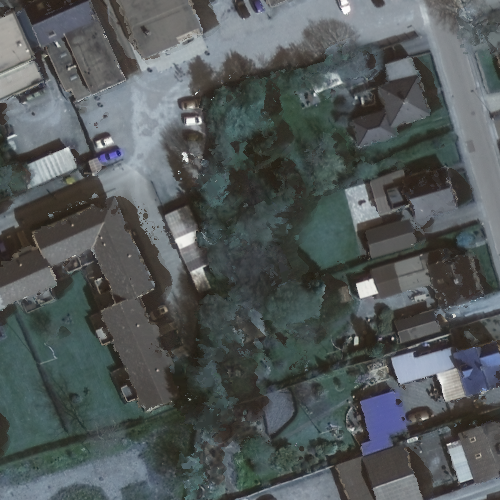

torch.Size([32, 3, 500, 500])
torch.Size([3, 500, 500])
torch.Size([500, 500])


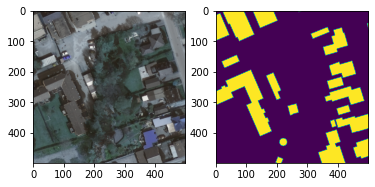

In [53]:
inputs, masks = next(iter(train_dataloader))

print(inputs.shape)
print(masks.shape)

image = inputs[0].numpy()
#print(image.astype(np.uint8))
img = Image.fromarray(image.astype(np.uint8))
# Display the image
img.show()


_, ax = plt.subplots(1,2)
ax[0].imshow(inputs[0].int())#permute(0,1,2))
ax[1].imshow(masks[0])


inputs = inputs.permute(0,3,1,2)
print(inputs.shape)
print(inputs[0].shape)
print(masks[0].shape)


test_in = inputs.to(device=device)


In [54]:
torch.cuda.empty_cache()
with torch.no_grad():
    #xb = xb.to(device=device)
    pred = model(test_in)
    print(pred.shape)

torch.Size([32, 1, 500, 500])


In [55]:
# Test torchmetrics jaccard index
from torchmetrics.classification import BinaryJaccardIndex

preds = pred
preds = torch.sigmoid(preds)    # Not sure if should use this, have to test
preds = torch.squeeze(preds)    # Remove the dimension with a 1 to make it same shape as target/mask.
preds = preds.cpu()
print(preds.shape)
target = masks
target = target.cpu()
print(target.shape)

torch.Size([32, 500, 500])
torch.Size([32, 500, 500])


In [56]:
# https://torchmetrics.readthedocs.io/en/stable/classification/jaccard_index.html
metric = BinaryJaccardIndex(threshold=0.5)#.to(device=device)
result_iou = metric(preds, target)
print(result_iou.item())

0.7837649583816528


In [57]:
print(pred.shape)

torch.Size([32, 1, 500, 500])


In [58]:
pred_1 = pred[0]
print(pred_1.shape)
print(pred_1)

torch.Size([1, 500, 500])
tensor([[[-2.1968, -2.8463, -3.4121,  ..., -0.8081, -0.7646, -0.8727],
         [-2.8526, -3.1259, -3.7143,  ..., -0.9227, -0.3711, -0.5635],
         [-3.5475, -3.1981, -3.7594,  ..., -1.6253, -1.2074, -1.5797],
         ...,
         [-5.5291, -5.9340, -5.8328,  ..., -6.4658, -6.8407, -5.9464],
         [-5.0015, -5.8659, -6.2101,  ..., -6.6995, -6.5813, -5.3851],
         [-4.3824, -5.9192, -6.4130,  ..., -5.9744, -5.4618, -4.2015]]],
       device='cuda:0')


In [59]:
pred_1 = torch.sigmoid(pred_1)
print(pred_1)

tensor([[[0.1000, 0.0549, 0.0319,  ..., 0.3083, 0.3176, 0.2947],
         [0.0545, 0.0421, 0.0238,  ..., 0.2844, 0.4083, 0.3627],
         [0.0280, 0.0392, 0.0228,  ..., 0.1645, 0.2302, 0.1708],
         ...,
         [0.0040, 0.0026, 0.0029,  ..., 0.0016, 0.0011, 0.0026],
         [0.0067, 0.0028, 0.0020,  ..., 0.0012, 0.0014, 0.0046],
         [0.0123, 0.0027, 0.0016,  ..., 0.0025, 0.0042, 0.0148]]],
       device='cuda:0')


In [60]:
pred = pred.cpu().numpy()

In [61]:
print(pred.shape)
pred_1 = pred[0]
print(pred_1.shape)

(32, 1, 500, 500)
(1, 500, 500)


In [62]:
pred_1 = np.squeeze(pred_1, axis=0)
print(pred_1.shape)

(500, 500)


In [63]:
pred_1 = pred_1 > 0.5
pred_1 = np.array(pred_1, dtype=np.uint8)
print(pred_1)
print(pred_1.max())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
1


In [64]:
print(masks[0])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [65]:
masks = masks.cpu().numpy()

In [66]:
print(masks.shape)
mask_1 = masks[0]
print(mask_1.shape)

(32, 500, 500)
(500, 500)


In [67]:
mask_1 = np.array(mask_1, dtype=np.uint8)
print(mask_1)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [68]:
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
def calculate_metrics(y_true, y_pred):
    """ Ground truth """
    #y_true = y_true.cpu().numpy()
    #y_true = y_true > 0.5
    #y_true = y_true.astype(np.uint8)
    #y_true = y_true.reshape(-1)

    """ Prediction """
    #y_pred = y_pred.cpu().numpy()
    #y_pred = y_pred > 0.5
    #y_pred = y_pred.astype(np.uint8)
    #y_pred = y_pred.reshape(-1)

    score_jaccard = jaccard_score(y_true, y_pred, average='micro')
    score_f1 = f1_score(y_true, y_pred, average='micro')
    score_recall = recall_score(y_true, y_pred, average='micro')
    score_precision = precision_score(y_true, y_pred, average='micro')
    score_acc = accuracy_score(y_true, y_pred)

    return [score_jaccard, score_f1, score_recall, score_precision, score_acc]

In [69]:
score = calculate_metrics(mask_1, pred_1)
print(score)

[0.8281936853365425, 0.9060240082648405, 0.8807166598531843, 0.9328287962649197, 0.0]


In [70]:
jaccard, f1, recall, precision, acc = score
print(f'Jaccard/IOU: {jaccard}, f1: {f1}, recall: {recall}, precision: {precision}, accuracy: {acc}')

Jaccard/IOU: 0.8281936853365425, f1: 0.9060240082648405, recall: 0.8807166598531843, precision: 0.9328287962649197, accuracy: 0.0


In [71]:
prediction_1 = torch.from_numpy(pred_1)
print(prediction_1)
print(inputs[0].shape)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)
torch.Size([3, 500, 500])


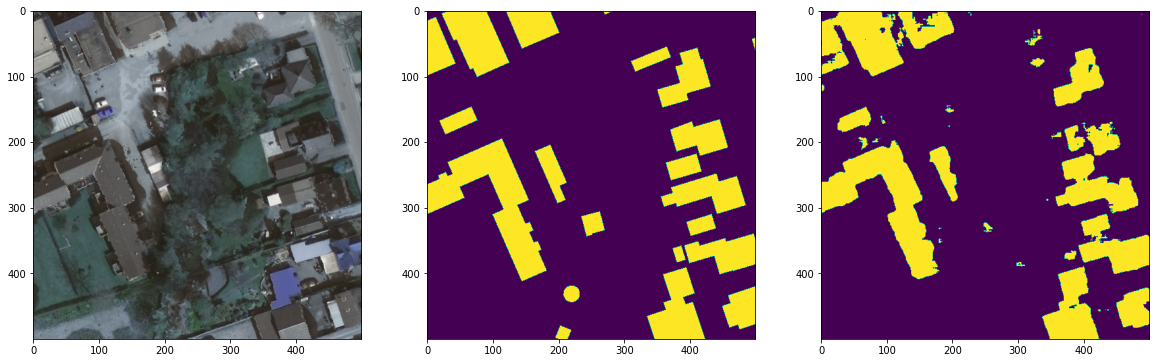

In [72]:
_, ax = plt.subplots(1,3, figsize=(20,20))
ax[0].imshow(inputs[0].int().permute(1,2,0))
ax[1].imshow(masks[0])
ax[2].imshow(prediction_1)
plt.savefig('image example-4_15.05.23.png')

In [73]:
#pred = pred.to(device=device)
#pred = pred.permute(0,1,3,2)
#pred = pred.cpu().numpy()

#single mask pred
print(pred.shape)
pred_1 = pred[0]
#pred_1 = np.squeeze(pred_1, axis=0) 
print(pred[0].shape)
print(pred[0])
#pred_1 = torch.sigmoid(pred_1)
#pred_2 = nn.torch.GELU(pred_1)
print(pred_1)
#ma_x = torch.max(pred_1)
#mi_n = torch.min(pred_1)
#print(ma_x)
#print(mi_n)
#print(masks[0])
#print(pred_2)

(32, 1, 500, 500)
(1, 500, 500)
[[[-2.1967955  -2.8463397  -3.412063   ... -0.80813974 -0.7646361
   -0.87269336]
  [-2.8526087  -3.1258748  -3.71435    ... -0.92269516 -0.37112248
   -0.56350446]
  [-3.5475266  -3.1981442  -3.7594385  ... -1.6252532  -1.2073907
   -1.5797446 ]
  ...
  [-5.529079   -5.9339533  -5.832795   ... -6.465804   -6.8406715
   -5.9464025 ]
  [-5.0014553  -5.8658533  -6.2101283  ... -6.6994905  -6.581281
   -5.3850665 ]
  [-4.382367   -5.9191995  -6.412977   ... -5.9744077  -5.461753
   -4.2014666 ]]]
[[[-2.1967955  -2.8463397  -3.412063   ... -0.80813974 -0.7646361
   -0.87269336]
  [-2.8526087  -3.1258748  -3.71435    ... -0.92269516 -0.37112248
   -0.56350446]
  [-3.5475266  -3.1981442  -3.7594385  ... -1.6252532  -1.2073907
   -1.5797446 ]
  ...
  [-5.529079   -5.9339533  -5.832795   ... -6.465804   -6.8406715
   -5.9464025 ]
  [-5.0014553  -5.8658533  -6.2101283  ... -6.6994905  -6.581281
   -5.3850665 ]
  [-4.382367   -5.9191995  -6.412977   ... -5.9744077